In [1]:
%run ./Vlad_Dissertation.ipynb

/home/renato/.virtualenvs/pps/lib/python3.11/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
/tmp/ipykernel_71213/1247435164.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


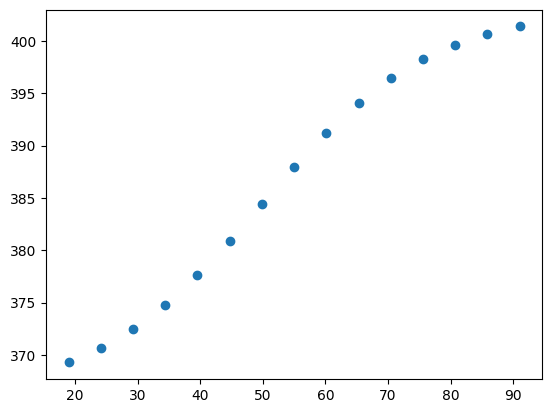

In [3]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
s_distances_sec = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
mydistances = 100 - s_distances_sec * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###Healthy Controls
ymin = 366
ymax = 403
scz_cp = 100 - 1.666 * 30
scz_slope = 1 / 0.075

SCZ_RTs = RTsig(mydistances, scz_cp, scz_slope)
plt.scatter(mydistances, SCZ_RTs)

In [4]:
from scipy.optimize import differential_evolution

HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)


def sczmodelrun(theta):
    SCZLt, SCZLa, SCZLv = Lw(
        theta[0], 0.05, 1, 4, theta[0], 0.05, 20, 80, theta[0], 0.05, 2, 8
    )
    _, _, _, _, SCZrt = experiment(
        ts,
        simtime,
        mydistances,
        5,
        SCZLt,
        SCZLa,
        SCZLv,
        HCWt,
        HCWa,
        HCWv,
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        theta[1],
        0,
    )

    xf = SCZrt
    yf = SCZ_RTs

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(0, 3), (0, 6.5)]
sczres = differential_evolution(
    sczmodelrun, bounds, disp=True, workers=-1, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 11.442265876271144
differential_evolution step 2: f(x)= 11.442265876271144
differential_evolution step 3: f(x)= 10.326870786147376
differential_evolution step 4: f(x)= 10.326870786147376
differential_evolution step 5: f(x)= 10.326870786147376
differential_evolution step 6: f(x)= 10.326870786147376
differential_evolution step 7: f(x)= 10.113499584740046
differential_evolution step 8: f(x)= 9.884666031133245
differential_evolution step 9: f(x)= 9.736156990289134
differential_evolution step 10: f(x)= 9.736156990289134
differential_evolution step 11: f(x)= 9.736156990289134
differential_evolution step 12: f(x)= 9.736156990289134
differential_evolution step 13: f(x)= 9.736156990289134
differential_evolution step 14: f(x)= 9.736156990289134
differential_evolution step 15: f(x)= 9.736156990289134
differential_evolution step 16: f(x)= 9.736156990289134
differential_evolution step 17: f(x)= 9.736156990289134
differential_evolution step 18: f(x)= 9.7361569902

In [6]:
print(sczres)

             message: Optimization terminated successfully.
             success: True
                 fun: 9.68499808793114
                   x: [ 1.963e+00  1.044e-01]
                 nit: 23
                nfev: 720
          population: [[ 1.963e+00  1.044e-01]
                       [ 1.967e+00  1.053e-01]
                       ...
                       [ 1.971e+00  1.043e-01]
                       [ 1.972e+00  1.137e-01]]
 population_energies: [ 9.685e+00  9.783e+00 ...  9.736e+00  9.736e+00]


In [7]:
## Fitted model

Lex, Pr = 1.963e00, 1.044e-01

SCZLt, SCZLa, SCZLv = Lw(Lex, 0.05, 1, 4, Lex, 0.05, 20, 80, Lex, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)
_, _, _, _, SCZ_Model_RTs = experiment(
    ts,
    simtime,
    mydistances,
    5,
    SCZLt,
    SCZLa,
    SCZLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    Pr,
    0,
)

0.9357750284613867 321.35442323696793


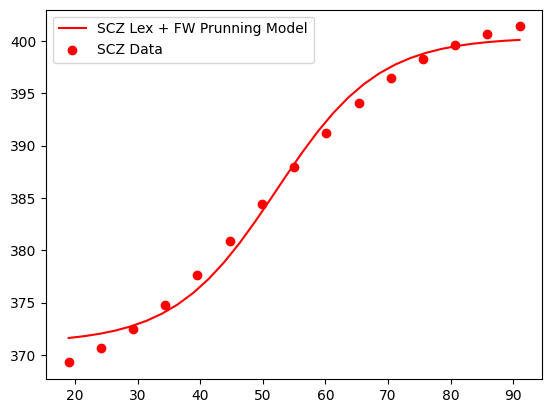

In [8]:
xf = SCZ_Model_RTs
yf = SCZ_RTs
m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
    xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
)
bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

ymin, ymax = np.min(m * xf + bias), np.max(m * xf + bias)
dc, h = fitting(mydistances, m * xf + bias)
mydistances_exp = np.linspace(mydistances[0], mydistances[-1], 30)
yf_exp = RTsig(mydistances_exp, dc, h)

plt.figure(1)
plt.plot(mydistances_exp, yf_exp, label="SCZ Lex + FW Prunning Model", color="r")
plt.scatter(mydistances, yf, label="SCZ Data", color="r")
plt.legend()
print(m, bias)

In [9]:
from sklearn import metrics

print(metrics.root_mean_squared_error(yf, m * xf + bias))

0.9659887733308142


In [10]:
def adjrmse(model, data, k):
    sse = np.sum(np.square(data - model))
    n = len(model)
    return np.sqrt(sse / (n - k))


scz_error = adjrmse(m * xf + bias, yf, 4)
print(scz_error)

1.1280318601648853
